This is Part IV of the notebook with some experiments in using the Yamnet pre-trained neural network for classifying and evaluating bird audio recordings from the Cacophony project.

In this notebook very large scale testing is performed on a signifcant part of the full Cacophony Database


See [part I](Yamnet_Audio_Classification_Experiments_Part_1.ipynb) for a full background

Quentin McDonald <br>
September 2021

In [464]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
plt.style.use('seaborn')
import datetime
from suntime import Sun, SunTimeException 


In [465]:
# CHRISTCHURCH LAT/LONG
lat = 43.5320
long = 172.6306
sun = Sun(lat, long)

In [466]:
# Most analyses will only
MIN_NUM_RECORDINGS = 1000

<H2> Processing and reading the data </H2>

The scoring is done with [this](score_db.py) Python script. For a given date range this script downloads each audio recording into a temporary memory buffer, scores it and adds the scores (along with the ID, some device info and the earlier Cacophony Index) into a record in the "scores.db" SQLite3 database.

In [526]:
con = sqlite3.connect("scores.db", detect_types=sqlite3.PARSE_DECLTYPES | sqlite3.PARSE_COLNAMES)
scores_df = pd.read_sql_query("SELECT * from scores", con)
con.close()

In [527]:
# A very few files are missing the Cacophony Index scoring so the script has set the value to -1. 
# Remove those records:
scores_df = scores_df[scores_df['ci_score'] >= 0.0 ]
# Convert dates to datetime objects
scores_df['ts'] = pd.to_datetime(scores_df['ts'], format='%Y-%m-%d %H:%M:%S', utc=True)
scores_df['ts'] = scores_df['ts'].dt.tz_convert('Pacific/Auckland')

In [528]:
scores_df.describe()

,id,dev_id,thresh_score,class_score,ci_score,latitude,longtitude
count,109276.000000,109276.000000,109276.000000,109276.000000,109276.000000,109276.000000,109276.000000
mean,816493.221613,1083.253487,0.179795,0.284099,0.514280,-39.465962,169.020891
std,65042.005853,352.122927,0.225527,0.260882,0.120494,7.302031,28.250778
min,712227.000000,476.000000,0.000000,0.000000,0.000000,-43.835850,-93.384450
25%,760122.750000,827.000000,0.020080,0.076305,0.423000,-43.580250,172.704150
50%,807905.500000,1234.000000,0.088353,0.192771,0.506000,-41.356350,173.621250
75%,869577.000000,1433.000000,0.240964,0.429719,0.589500,-37.290150,174.573450
max,942561.000000,1596.000000,0.991968,0.991968,0.833000,56.211750,176.210550


In [529]:
scores_df.head()

,id,ts,dev_name,dev_id,thresh_score,class_score,ci_score,latitude,longtitude
0,712227,2020-11-01 00:04:27+13:00,Pararaki,1258,0.084337,0.341365,0.3355,-39.05955,174.01815
1,712230,2020-11-01 00:28:26+13:00,elorosa1,827,0.000000,0.028112,0.5155,-41.35635,173.62125
2,712246,2020-11-01 01:09:12+13:00,elorosa1,827,0.000000,0.012048,0.5240,-41.35635,173.62125
3,712263,2020-11-01 00:42:10+13:00,Moturoa,1260,0.453815,0.871486,0.4780,-39.06135,174.02085
4,712265,2020-11-01 00:43:11+13:00,Moturoa,1260,0.497992,0.923695,0.4690,-39.06135,174.02085


<H2> Score by day over the entire dataset </H2>


In [530]:
def plot_scores_by_day(df, method='mean', normalize_by_daylight_hours = False,
                      show_class=True, show_thresh=True, show_ci = True, show_daylight_hours = True):
    """
    For the score data in df, plot the mean or median score per day for each of the three scores
    depending on "method"
    
    """
    
    def calc_daylight_hours(day):
        """
        Calculate the number of daylight hours on the given day:
        """
        local_day = datetime.date(day.year,day.month,day.day)
        sr = sun.get_local_sunrise_time(local_day)
        ss = sun.get_local_sunset_time(local_day)
        return (sr-ss)/datetime.timedelta(hours=1)
    
    
    if method == 'mean':
        scores_by_day_df = df.groupby(by=df['ts'].dt.date).mean()
        mth = "Mean"
    elif method=='median':
        scores_by_day_df = df.groupby(by=df['ts'].dt.date).median()
        mth = "Median"
    else:
        raise ValueError("Invalid method " + method)
    
    
    
    scores_by_day_df['daylight_hours'] = scores_by_day_df.index.map(calc_daylight_hours)
    
    
    if( normalize_by_daylight_hours ):
        scores_by_day_df['class_score'] = scores_by_day_df['class_score']/scores_by_day_df['daylight_hours'] 
        scores_by_day_df['thresh_score'] = scores_by_day_df['thresh_score']/scores_by_day_df['daylight_hours'] 
        scores_by_day_df['ci_score'] = scores_by_day_df['ci_score']/scores_by_day_df['daylight_hours'] 
        
        
    scores_by_day_df['class_score_ema'] = scores_by_day_df['class_score'].ewm(span=60,adjust=False).mean()
    scores_by_day_df['thresh_score_ema'] = scores_by_day_df['thresh_score'].ewm(span=60,adjust=False).mean()
    scores_by_day_df['ci_score_ema'] = scores_by_day_df['ci_score'].ewm(span=60,adjust=False).mean()
    
    
    fig = plt.figure(2,figsize=(12,10))
    ax = fig.subplots(1)
    ax.set_xlabel("Date")
    ax.set_ylabel("Score")
    
    lns = []
    
    if show_class:
        l = ax.plot(scores_by_day_df['class_score'], c="#222299", linewidth=1,label="Class Score")
        ax.plot(scores_by_day_df['class_score_ema'], linewidth=2,linestyle='dotted',c="#222299")
        lns = lns + l
    
    if show_thresh:
        l = ax.plot(scores_by_day_df['thresh_score'], c="#DD8822", linewidth=1,label="Threshold Score")
        ax.plot(scores_by_day_df['thresh_score_ema'], linewidth=2,linestyle='dotted',c="#DD8822")
        lns = lns + l
    
    if show_ci:
        l = ax.plot(scores_by_day_df['ci_score'], c="#228822",linewidth=1, label="CI Score")
        ax.plot(scores_by_day_df['ci_score_ema'], linewidth=2,linestyle='dotted',c="#228822")
        lns = lns + l
        
    if normalize_by_daylight_hours:
        norm = "normalized by daylight hours"
    else:
        norm = ""
    ax.set_title("{} Bird Count Scores per day over all Cacphony recordings {}\nShowing exponential moving averages".
                format(mth, norm))
   
    if show_daylight_hours:
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        l = ax2.plot(scores_by_day_df['daylight_hours'],c='#AA2255',linewidth=2,linestyle='dashed',
                    label='Daylight Hours')
        ax2.set_ylabel("Daylight Hours")
        lns = lns + l
        
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%h-%y'))
    
    
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    
    
    plt.show()

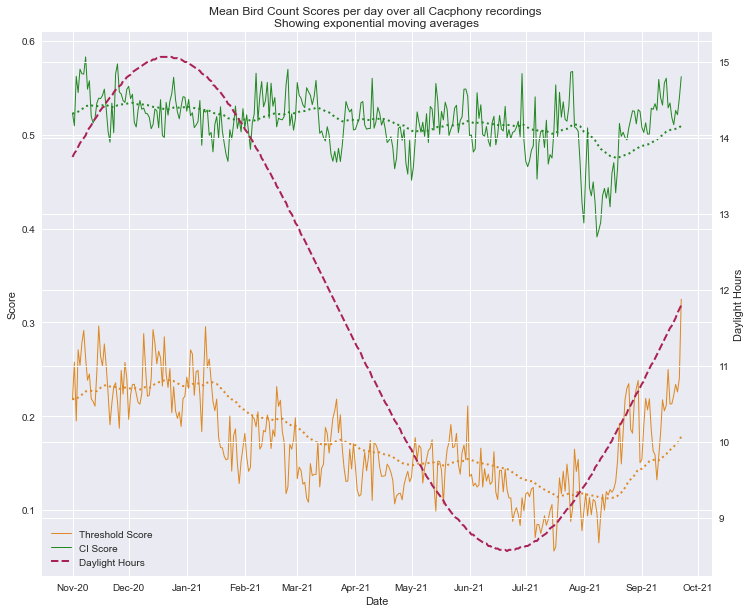

In [531]:
plot_scores_by_day(scores_df,method="mean", show_class=False)

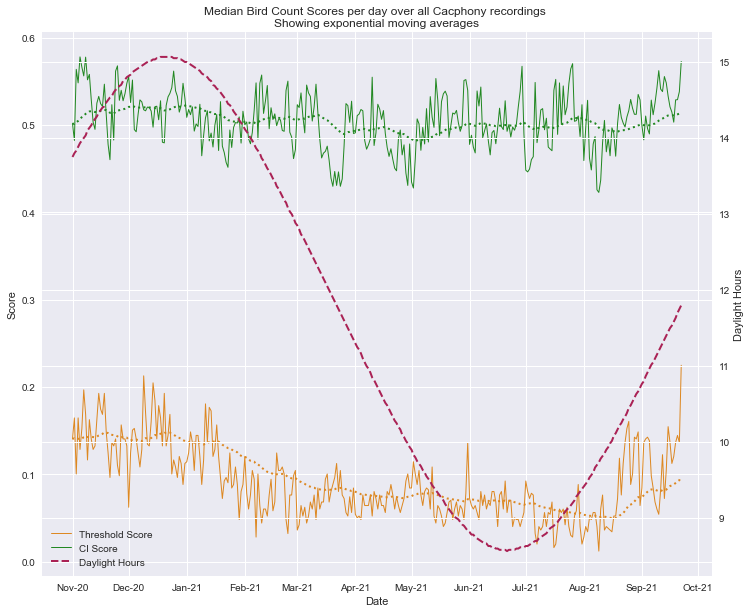

In [532]:
plot_scores_by_day(scores_df,method="median", show_class=False)

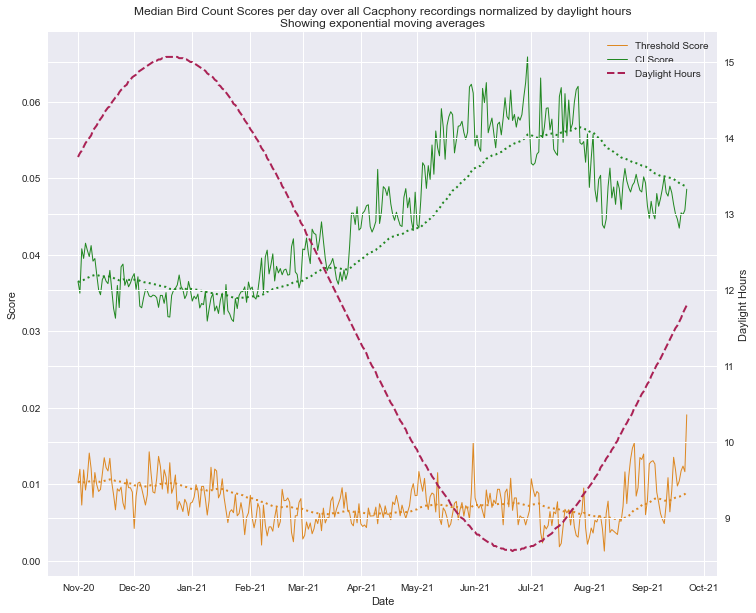

In [533]:
plot_scores_by_day(scores_df, method="median",normalize_by_daylight_hours=True, show_class=False)

In [534]:
def plot_counts_by_day(df):
    """
    For the score data in df, plot the number of recordings per day
    
    """
    counts_by_day_df = df.groupby(by=df['ts'].dt.date).count()
    counts_by_day_df['id_ema'] = counts_by_day_df['id'].ewm(span=60,adjust=False).mean()
   
    fig = plt.figure(2,figsize=(12,10))
    ax = fig.subplots(1)
    
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of Recordings")
    ax.plot(counts_by_day_df['id'], c="#222299", linewidth=1)
    ax.plot(counts_by_day_df['id_ema'], linewidth=2,linestyle='dotted',c="#222299")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%h-%y'))
    
    ax.set_title("Number of recordings per day over all Cacphony recordings\nShowing exponential moving averages")
   
    plt.show()

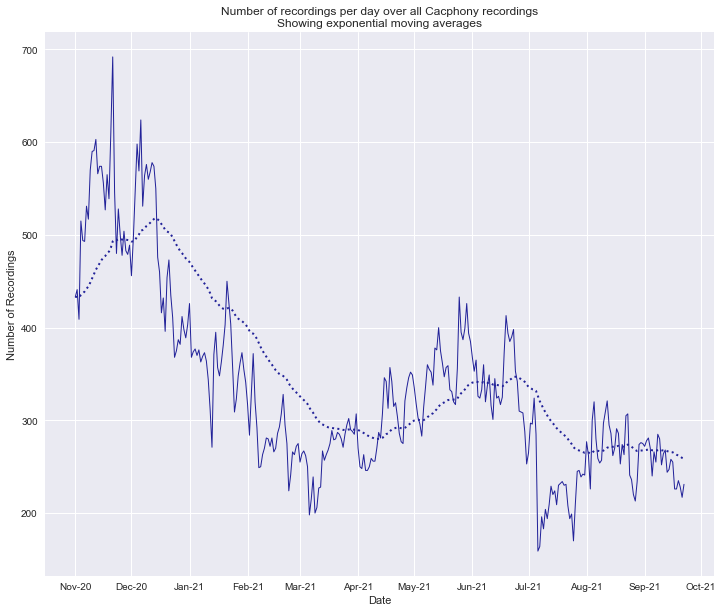

In [535]:
plot_counts_by_day(scores_df)

<H3> Device continuity over time </H3>

In [538]:
def plot_device_recordings(df, min_num_recordings=1000):
    """
    Create a matrix of those devices with at least 'min_num_recordings'showing which days they uploaded
    a recording

    """
    def assign_recordings_to_mat(ts,dev_name, mat, start_date, dev_to_idx):
        day = ts.date()
        day_idx = int((day-start_date)/datetime.timedelta(days=1))
        if dev_name in dev_to_idx:
            dev_idx=dev_to_idx[dev_name]
            mat[day_idx,dev_idx] = dev_idx + 1
        
        
    # Create a dataframe grouped by day - index will be days
    counts_by_day_df = df.groupby(by=df['ts'].dt.date).count()
    days = np.array(counts_by_day_df.index)
    days_len = int((days[-1] - days[0])/datetime.timedelta(days=1)) +1
    counts_by_dev_df = df.groupby(by=df['dev_name']).count()
    counts_by_dev_df = counts_by_dev_df[counts_by_dev_df['id'] > min_num_recordings]
    counts_by_dev_df = counts_by_dev_df.sort_values(by='id', ascending = False )
    devs = np.array(counts_by_dev_df.index)
    
    # Create the matrix:
    mat = np.zeros((days_len,len(devs)), dtype=np.int8)
    
    dev_to_idx = {}
    dev_to_idx = { devs[i] : i for i in range(len(devs))}
    
    earliest_date = days[0]
    
    # Iterate over the recordings and assign each one of them to the matrix of recordings:
    result=[assign_recordings_to_mat(x,y, mat,earliest_date, dev_to_idx) for x,y in zip(df['ts'],df['dev_name']) ]
    
    fig = plt.figure(2,figsize=(12,10))
    ax = fig.subplots(1)
    ax.set_yticks([x for x in range(len(devs))])
    ax.set_yticklabels(devs)
    # mask some 'bad' data, in your case you would have: data == 0
    mat = np.ma.masked_where(mat < 0.05, mat)

    
    cmap = plt.cm.get_cmap("tab20b").copy()

    cmap.set_bad(color='black')
    xlims = [days[0],days[-1]]
    xlims =  mdates.date2num(xlims)
    ax.imshow(mat.T, aspect='auto', interpolation='none', cmap=cmap, extent=[xlims[0],xlims[1],len(devs),0])
    ax.grid(False, axis="y")
    ax.grid(True,axis="x", linewidth=0.5,c="#DDDDDD")
    ax.set_ylabel("Device Name")
    ax.set_xlabel("Date")
    ax.xaxis_date()
    date_format = mdates.DateFormatter('%h-%y')
    ax.yaxis.set(ticks=np.arange(0.5, len(devs)), ticklabels=devs)
    ax.xaxis.set_major_formatter(date_format)

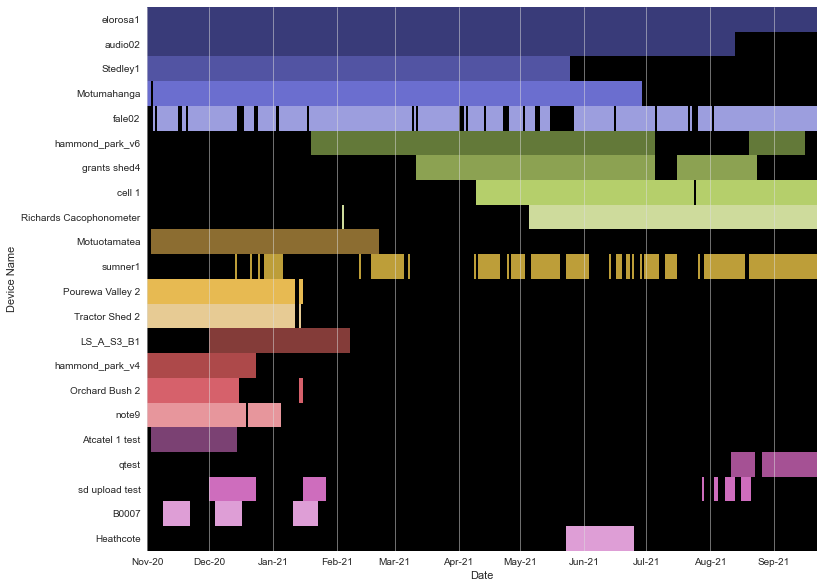

In [539]:
plot_device_recordings(scores_df, min_num_recordings = MIN_NUM_RECORDINGS)


<H2> Mean score around sunrise </H2>
Examine the trends in the mean score one hour either side of sunrise